In [1]:
import numpy as np
import json as js
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import pandas as pd
from sklearn.decomposition import PCA

from nona.nona import nona

In [2]:
#load data


base_dir = "c:\\Users\\1\\Desktop\\datasets"
def data_loader(base_dir, max_data, start_position=0):

    data_buffer = {}

    for json_file in os.listdir(base_dir)[:-1]:


        curent_file = os.path.join(base_dir, json_file)
        curent_data_buffer = {}
        with open (curent_file) as file:

            json_data = file.readlines()
            json_data = json_data[start_position: max_data]

            for (json_number, json_per_line) in enumerate(json_data):
                
            
                json_format = js.loads(json_per_line)
                curent_data_buffer[f"subject_number: {json_number}"] = json_format
        
        data_buffer[json_file] = curent_data_buffer


    person_id_list = []
    for data_batch in data_buffer.keys():
        for subject in data_buffer[data_batch].keys():

            person_id_list.append(data_buffer[data_batch][subject]["profile_id"])


    person_log_file = os.path.join(base_dir, os.listdir(base_dir)[-1])
    person_info_buffer = {}

    with open(person_log_file) as file:

        json_data = file.readlines()
        for (json_number, json_per_line) in enumerate(json_data):

            json_format_data = js.loads(json_per_line)
            if json_format_data["id"] in person_id_list:

                person_info_buffer[json_format_data["id"]] = json_format_data
    
    return data_buffer, person_info_buffer


data_buffer, person_info_buffer = data_loader(base_dir=base_dir, max_data=2000)

keys = [key for key in person_info_buffer.keys()]
print(person_info_buffer[keys[0]])




{'id': 'SoNAuI4y0kgDCqCd0E3ruHH-V84jY7fDJxovrTVh8pE', 'birth_date': 800, 'hr_rest': 60, 'hr_max': 170, 'sex': 'female', 'weight': 76}


[-12.483387472509676, -0.11775995130831234, 64.27096443649188, 1.5152217795665586, -45.6725524187011, 24.880489122114234, -1.7493328774585386, 43.341733816217534, -1.5031257626804178, -11.2868649024288]
[144.99256806 -37.72401844  18.15140246 -18.93892632 181.45184904
 160.43957333  59.95906702 141.20483158 -14.22305435   7.39635199]


In [3]:
def generate_data_frame(data_buffer, person_info_buffer):

    data_list = [] 
    subjects_features = ["start_millis", "stop_millis", "skllzz", 
                             "activity_day", "skllzz_with_artifacts", "skllzz_without_artifacts", 
                             "steps", "day", "meters", 
                             "birth_date", "hr_rest", "hr_max", 
                             "weight"]
    
    for (batch_number, data_batch) in enumerate(data_buffer):

        sub_info = []
        subjects = [key for key in data_buffer[data_batch].keys()]
        subjects_id = [data_buffer[data_batch][subject]["profile_id"] for subject in subjects]

        for feature in subjects_features:
            
            subject_feature_list = []
            for (subject, subject_id) in zip(subjects, subjects_id):
                
                if feature in ["day", "meters", "steps"]:

                    if feature in data_buffer[data_batch][subject]["steps"].keys():
                        subject_feature_list.append(float(data_buffer[data_batch][subject]["steps"][feature]))

                    else:
                        subject_feature_list.append(0.0)
                
                elif feature in ["hr_max", "hr_rest", "weight", "birth_date"]:

                    if feature in person_info_buffer[subject_id].keys():
                        subject_feature_list.append(float(person_info_buffer[subject_id][feature]))
                    
                    else:
                        subject_feature_list.append(0.0)
                
                elif feature in ["stop_millis", "start_millis"]:

                    if feature in data_buffer[data_batch][subject].keys():
                        
                        formated_millis = float(data_buffer[data_batch][subject][feature]) * 3.6e+6
                        subject_feature_list.append(formated_millis)

                    else:
                        subject_feature_list.append(0.0)

                else:

                    if feature in data_buffer[data_batch][subject].keys():
                        subject_feature_list.append(float(data_buffer[data_batch][subject][feature]))
                    
                    else:
                        subject_feature_list.append(0.0)
            
            sub_info.append(subject_feature_list)
        sub_info_tensor = np.asarray(sub_info, dtype="float32")
        


        for (subject_number, subject) in enumerate(data_buffer[data_batch].keys()):

            add_vector = list(sub_info_tensor[:, subject_number]) + [batch_number, ]

            if "samples" in data_buffer[data_batch][subject]["steps"].keys():

                min_var = 1000000000000000000000000000
                samples_data = np.asarray([[float(sample[feature]) for feature in sample.keys() if feature != "duration"] for sample in data_buffer[data_batch][subject]["steps"]["samples"]])
                mean_vector = [np.mean(samples_data[:, vector_number]) for vector_number in range(samples_data.shape[1])]
                optim_vector = None

                for sample in data_buffer[data_batch][subject]["steps"]["samples"]:
                    
                    sample_vector = np.asarray([float(sample[feature]) for feature in sample.keys() if feature != "duration"])
                    if min_var > (np.dot(sample_vector, mean_vector)):

                        min_var = (np.dot(sample_vector, mean_vector))
                        optim_vector = list(sample_vector)


                optim_vector += add_vector
                optim_vector = np.asarray(optim_vector)
                optim_vector[0] *= 3.6e+6


            else:
                optim_vector = [0.0, 0.0] + add_vector
            
            data_list.append(optim_vector)



    all_features = ["stamp_millis", "steps"] + subjects_features + ["class_labels", ]
    data_tensor = np.asarray(data_list)
    data_frame = pd.DataFrame(data=data_tensor,
                              columns=all_features)
    
    return (data_frame, data_tensor)
    

data_frame, data_tensor = generate_data_frame(data_buffer=data_buffer, person_info_buffer=person_info_buffer)
print(data_frame)
            

      stamp_millis  steps  start_millis   stop_millis     skllzz   
0     6.086214e+18   10.0  6.086081e+18  6.086392e+18  48.959999  \
1     6.086392e+18   23.0  6.086392e+18  6.086703e+18  30.476000   
2     6.086820e+18   16.0  6.086703e+18  6.087014e+18  27.903999   
3     6.087147e+18   17.0  6.087014e+18  6.087325e+18  17.864000   
4     6.087425e+18   41.0  6.087325e+18  6.087636e+18  20.900000   
...            ...    ...           ...           ...        ...   
3995  6.128133e+18   11.0  6.128071e+18  6.128382e+18  29.823999   
3996  6.076750e+18   15.0  6.076750e+18  6.077061e+18  34.939999   
3997  6.139369e+18   88.0  6.139269e+18  6.139579e+18  69.031998   
3998  6.099258e+18   79.0  6.099144e+18  6.099456e+18  29.691999   
3999  6.090500e+18    2.0  6.090435e+18  6.090746e+18  62.312000   

      activity_day  skllzz_with_artifacts  skllzz_without_artifacts    steps   
0           1305.0               0.000000                 48.959999  12240.0  \
1           1306.0     

In [96]:
def mean_data_adoption(data_tensor):

    result_data_tensor = np.zeros(shape=data_tensor.shape)
    for index_i in range(data_tensor.shape[0]):
        for index_j in range(data_tensor.shape[1]):

            if (data_tensor[index_i, index_j] == 0.0) and (index_j != (data_tensor.shape[1] - 1)):

                result_data_tensor[index_i, index_j] = np.mean(data_tensor[:, index_j])

            else:

                result_data_tensor[index_i, index_j] = data_tensor[index_i, index_j]
    
    return result_data_tensor

data_tensor_mean = mean_data_adoption(data_tensor)
print(data_tensor_mean)


[[6.08638860e+18 7.50000000e+03 1.88000000e+02 ... 1.86000000e+02
  1.05000000e+02 0.00000000e+00]
 [6.08668344e+18 7.50000000e+03 3.00000000e+01 ... 1.86000000e+02
  1.05000000e+02 0.00000000e+00]
 [6.08701068e+18 7.50000000e+03 3.50000000e+01 ... 1.86000000e+02
  1.05000000e+02 0.00000000e+00]
 ...
 [6.13957644e+18 7.50000000e+03 5.70000000e+01 ... 1.80000000e+02
  1.10000000e+02 1.00000000e+00]
 [6.09941988e+18 7.50000000e+03 2.90000000e+01 ... 1.98000000e+02
  7.76999969e+01 1.00000000e+00]
 [6.09073020e+18 7.50000000e+03 7.10000000e+01 ... 1.81000000e+02
  9.70000000e+01 1.00000000e+00]]


In [27]:

def generate_data(data_buffer, person_info_buffer, max_from_samples=0.0, generation_type="all"):

    data_list = []
    for (batch_number, data_batch) in enumerate(data_buffer.keys()):

        gender_labels = {
            "male": 1.0,
            "female": 2.0
        }

        personal_goal_labels = {
            "unknown_goal": 0.0,
            "lose_weight": 1.0,
            "childrens_training": 2.0,
            "relief": 3.0,
            "strength": 4.0,
            "antistress": 5.0,
            "learn_swim": 6.0,
            "flexibility": 7.0,
            "body_balance": 8.0,
            "fun": 9.0,
            "rehabilitation": 10.0
        }

        
        for subject in data_buffer[data_batch].keys():


            curent_person_id = data_buffer[data_batch][subject]["profile_id"]
            curent_person_object = person_info_buffer[curent_person_id]
        
            
            if "samples" in data_buffer[data_batch][subject]["steps"]:
                
                
                if "skllzz_with_artifacts" in data_buffer[data_batch][subject].keys():

                    subject_general_data = [
                        (float(data_buffer[data_batch][subject]["stop_millis"]) * (10 ** -5)) - (float(data_buffer[data_batch][subject]["start_millis"]) * (10 ** -5)),
                        float(data_buffer[data_batch][subject]["skllzz"]),
                        float(data_buffer[data_batch][subject]["activity_day"]),
                        float(data_buffer[data_batch][subject]["skllzz_with_artifacts"]),
                        float(data_buffer[data_batch][subject]["skllzz_without_artifacts"]), 
                    ]

                else:

                    subject_general_data = [
                        (float(data_buffer[data_batch][subject]["stop_millis"]) * (10 ** -5)) - (float(data_buffer[data_batch][subject]["start_millis"]) * (10 ** -5)),
                        float(data_buffer[data_batch][subject]["skllzz"]),
                        float(data_buffer[data_batch][subject]["activity_day"]),
                        0.0,
                        float(data_buffer[data_batch][subject]["skllzz_without_artifacts"]), 
                    ]
                
                subject_pysical_data = [
                    float(data_buffer[data_batch][subject]["steps"]["steps"]),
                    float(data_buffer[data_batch][subject]["steps"]["day"]),
                    float(data_buffer[data_batch][subject]["steps"]["meters"]) / 100
                ]

                subject_personal_data = [
                    float(curent_person_object["birth_date"]) / 360,
                    float(curent_person_object["hr_rest"]),
                    float(curent_person_object["hr_max"]),
                    float(curent_person_object["weight"])
                ]

                if "personal_goals" in curent_person_object.keys():

                    subject_personal_goals = [personal_goal_labels[goal] for goal in curent_person_object["personal_goals"]]
                    if len(subject_personal_goals) != len(personal_goal_labels):

                        kernel = [personal_goal_labels["unknown_goal"] for _ in range(len(personal_goal_labels) - len(subject_personal_goals))]
                        subject_personal_goals += kernel
                
                else:

                    subject_personal_goals = [personal_goal_labels["unknown_goal"] for _ in range(len(personal_goal_labels))]
                
               

                if "skllzz_with_artifacts" in data_buffer[data_batch][subject].keys():
                    subject_general_data.append(data_buffer[data_batch][subject]["skllzz_with_artifacts"])
                
                else:
                    subject_general_data.append(0.0)
                
                add_vector = subject_general_data + subject_pysical_data + subject_personal_data + subject_personal_goals
                add_vector.append(float(batch_number))
                




                if generation_type == "per_day":

                    for sample in data_buffer[data_batch][subject]["steps"]["samples"]:

                        sample_data = [float(feature) for feature in sample.values()]
                        sample_data[0] *= (10 ** -5)
                        sample_data[1] /= 3600.0

                        sample_data += add_vector
                        
                        # if len(sample_data) == 18:

                        #     data_list.append(sample_data)
                        
                        data_list.append(sample_data)
                
                elif generation_type == "all":

                    samples_data_list = []
                    for sample in data_buffer[data_batch][subject]["steps"]["samples"]:
                        
                        sample_data = [float(feature) for feature in sample.values()]
                        sample_data[0] *= (10 ** -5)
                        sample_data[1] /= 3600.0
                        
                        samples_data_list += sample_data
                        samples_data_list += add_vector

                        data_list.append(samples_data_list)

                else:

                    raise ValueError("you must condider data generation type ['all' or 'per_daya']")



    
    if generation_type == "all":

        if max_from_samples is 0.0:

            max_sample_len = max([len(sample) for sample in data_list])

        else:

            max_sample_len = max_from_samples

        data_tensor = np.zeros(shape=(len(data_list), max_sample_len))

        for sample_number in range(data_tensor.shape[0]):

            if data_list[sample_number] != data_tensor.shape[1]:

                class_label = data_list[sample_number][-1]
                none_class_list = data_list[sample_number][:-1]
                kernel_add = [0. for _ in range((max_sample_len - len(none_class_list)) - 1)]
                
                result_vector = none_class_list + kernel_add
                result_vector.append(class_label)
                result_vector = np.asarray(result_vector)
            
            else:

                result_vector = np.asarray(data_list[sample_number])
            
            data_tensor[sample_number] = result_vector
    
    elif generation_type == "per_day":

        data_tensor = np.asarray(data_list)

    return data_tensor


data_tensor = generate_data(data_buffer=data_buffer, generation_type="per_day", person_info_buffer=person_info_buffer)
print(data_tensor, data_tensor.shape)
plt.imshow(data_tensor, cmap="magma")
plt.show()





[[1.6906149e+07 2.5000000e+02 1.0000000e+01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.6906158e+07 2.5000000e+02 1.3000000e+01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.6906167e+07 2.5000000e+02 7.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [1.6918677e+07 2.5000000e+02 7.1000000e+01 ... 0.0000000e+00
  0.0000000e+00 1.0000000e+00]
 [1.6918686e+07 2.5000000e+02 7.1000000e+01 ... 0.0000000e+00
  0.0000000e+00 1.0000000e+00]
 [1.6918695e+07 2.5000000e+02 7.1000000e+01 ... 0.0000000e+00
  0.0000000e+00 1.0000000e+00]] (137141, 28)


[[[1.6906149e+12 9.0000000e+05 1.0000000e+01 ... 1.8600000e+02
   1.0500000e+02 0.0000000e+00]
  [1.6906158e+12 9.0000000e+05 1.3000000e+01 ... 1.8600000e+02
   1.0500000e+02 0.0000000e+00]
  [1.6906167e+12 9.0000000e+05 7.0000000e+00 ... 1.8600000e+02
   1.0500000e+02 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]]

 [[1.6906644e+12 9.0000000e+05 2.3000000e+01 ... 1.8600000e+02
   1.0500000e+02 0.0000000e+00]
  [1.6906959e+12 9.0000000e+05 1.1000000e+01 ... 1.8600000e+02
   1.0500000e+02 0.0000000e+00]
  [1.6906977e+12 9.0000000e+05 4.7300000e+02 ... 1.8600000e+02
   1.0500000e+02 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.000

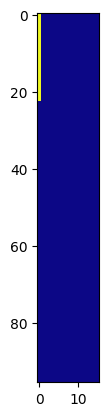

In [26]:
def simple_data_generation(data_buffer, person_info_buffer):

    data_list = []

    max_samples_number_chiters = max([len(data_buffer["activity_step_cheaters.jsonl"][subject]["steps"]["samples"]) 
                                      for subject in data_buffer["activity_step_cheaters.jsonl"].keys() 
                                      if "samples" in data_buffer["activity_step_cheaters.jsonl"][subject]["steps"].keys()])
    

    max_samples_number_none_chiters = max([len(data_buffer["activity_step_ok.jsonl"][subject]["steps"]["samples"]) 
                                           for subject in data_buffer["activity_step_ok.jsonl"].keys()
                                           if "samples" in data_buffer["activity_step_ok.jsonl"][subject]["steps"].keys()])
    

    general_max_number = max([max_samples_number_chiters, max_samples_number_none_chiters])

    for (batch_number, data_batch) in enumerate(data_buffer.keys()):
        for subject in data_buffer[data_batch].keys():
            
            curent_person_id = data_buffer[data_batch][subject]["profile_id"]
            curent_person_object = person_info_buffer[curent_person_id]

            if "samples" in data_buffer[data_batch][subject]["steps"].keys():

                if "skllzz_with_artifacts" in data_buffer[data_batch][subject].keys():

                    subject_general_data = [
                        (float(data_buffer[data_batch][subject]["stop_millis"]) * (10 ** -5)) - (float(data_buffer[data_batch][subject]["start_millis"]) * (10 ** -5)),
                        float(data_buffer[data_batch][subject]["skllzz"]),
                        float(data_buffer[data_batch][subject]["activity_day"]),
                        float(data_buffer[data_batch][subject]["skllzz_with_artifacts"]),
                        float(data_buffer[data_batch][subject]["skllzz_without_artifacts"]), 
                    ]

                else:

                    subject_general_data = [
                        (float(data_buffer[data_batch][subject]["stop_millis"]) * (10 ** -5)) - (float(data_buffer[data_batch][subject]["start_millis"]) * (10 ** -5)),
                        float(data_buffer[data_batch][subject]["skllzz"]),
                        float(data_buffer[data_batch][subject]["activity_day"]),
                        0.0,
                        float(data_buffer[data_batch][subject]["skllzz_without_artifacts"]), 
                    ]
                
                subject_pysical_data = [
                    float(data_buffer[data_batch][subject]["steps"]["steps"]),
                    float(data_buffer[data_batch][subject]["steps"]["day"]),
                    float(data_buffer[data_batch][subject]["steps"]["meters"]) / 100
                ]

                subject_personal_data = [
                    float(curent_person_object["birth_date"]) / 360,
                    float(curent_person_object["hr_rest"]),
                    float(curent_person_object["hr_max"]),
                    float(curent_person_object["weight"])
                ]
                
                add_vector = subject_general_data + subject_pysical_data + subject_personal_data + [batch_number, ]
                samples = [[float(feature) for feature in samples.values()] + add_vector for samples in data_buffer[data_batch][subject]["steps"]["samples"]]
                

                if len(samples) != general_max_number:

                    kernel = [[0.0 for _ in range(len(samples[0]))]  for _ in range(general_max_number - len(samples))]
                    samples += kernel
                
                data_list.append(samples)
                
    
    data_tensor = np.asarray(data_list)
    return data_tensor

data_tensor = simple_data_generation(data_buffer=data_buffer, person_info_buffer=person_info_buffer)
print(data_tensor, data_tensor.shape)

#plt.imshow(data_tensor[0], cmap="magma")
plt.imshow(data_tensor[1], cmap="plasma")
#plt.imshow(data_tensor[23], cmap="viridis")

plt.show()

[[-0.79188856 -0.8547779   1.01407913 ... -0.89139833 -1.53898004
   0.1347942 ]
 [-1.42919296  1.69037361  0.06793479 ...  1.03530471  0.39419781
  -0.74038293]
 [ 0.75303347 -0.54809068  0.17287871 ... -0.49447922 -0.26617547
  -1.39844156]
 ...
 [-0.20312995  0.15328476 -1.15612387 ... -0.80203481 -0.97579582
  -0.0137399 ]
 [-0.85154755  3.03447454  1.48356983 ...  0.88932082  0.00623035
  -0.1924991 ]
 [ 0.45239381  0.0685642  -1.20668689 ...  1.02558209 -0.04991884
   1.13780087]] [1. 1. 1. ... 0. 1. 1.]


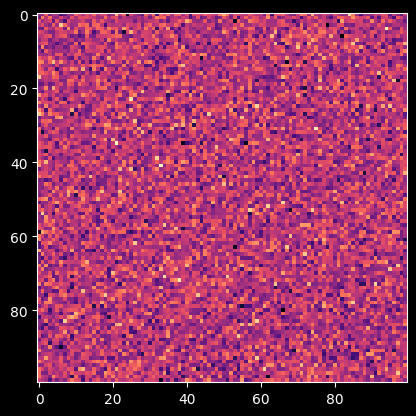

In [61]:
def expand_randomization(data_tensor, need_shape):


    permutated_data_tensor = np.random.permutation(data_tensor)

    sub_tensor = np.zeros(shape=(data_tensor[0, :-1].shape[0], need_shape))
    result_tensor = np.dot(permutated_data_tensor[:, :-1], sub_tensor)
    result_tensor += np.random.normal(0.34, 1.984, result_tensor.shape)
    result_tensor_std = (result_tensor - np.mean(result_tensor)) / np.std(result_tensor)
    result_data_tensor = np.zeros(shape=(result_tensor_std.shape[0], result_tensor_std.shape[1] + 1))
    result_data_tensor[:, :-1] = result_tensor_std
    result_data_tensor[:, -1] = permutated_data_tensor[:, -1]
    
    return result_data_tensor

preprocessed_data = expand_randomization(data_tensor, need_shape=100)

train_data = preprocessed_data[:preprocessed_data.shape[0] // 2, :-1]
validation_data = preprocessed_data[preprocessed_data.shape[0] // 2:, :-1]

train_label = preprocessed_data[:preprocessed_data.shape[0] // 2, -1]
validation_label = preprocessed_data[preprocessed_data.shape[0] // 2, -1]

print(train_data, train_label)
plt.imshow(train_data[:100], cmap="magma")


    

[[ 2.94610316  1.00565908  4.25927204 ...  0.98420021  1.27289528
   0.75603185]
 [ 1.34958648  1.44856348  1.94108909 ... -0.40903133 -0.68230859
   2.10772884]
 [ 4.46936872  0.81386043  3.89299272 ...  0.78349218 -3.39458052
   0.97890493]
 ...
 [ 4.15718162  2.10339052 -1.04126024 ... -0.75997482 -2.34143232
   2.2878033 ]
 [-0.75664585 -0.70836826  2.51596251 ... -1.89648218 -1.67888802
  -1.84686319]
 [ 1.67871804  1.465832    1.42640004 ...  0.74575228  1.25294774
   0.00837218]]


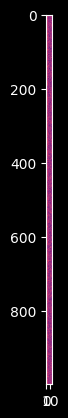

1018
982


In [18]:
data_permutated = np.random.permutation(data_tensor)


train_data = data_permutated[: data_permutated.shape[0] // 2, :-1]
train_labels = data_permutated[: data_permutated.shape[0] // 2, -1]

validation_data = data_permutated[data_permutated.shape[0] // 2: , :-1]
validation_labels = data_permutated[data_permutated.shape[0] // 2: , -1]

train_data_std = (train_data - np.mean(train_data)) / np.std(train_data)
validation_data_std = (validation_data - np.mean(validation_data)) / np.std(validation_data)

train_data_std += np.random.normal(0.34, 1.984, train_data_std.shape)
validation_data_std += np.random.normal(0.43, 1.984, validation_data_std.shape)

need_indexes_v = [index for index in range(validation_labels.shape[0]) if validation_labels[index] == 0.0]
need_indexes_t = [index for index in range(train_labels.shape[0]) if train_labels[index] == 0.0]

# pca_estimator = PCA(n_components=3)
# train_data_PCA = pca_estimator.fit_transform(train_data)
# validation_data_PCA = pca_estimator.fit_transform(validation_data)


# pca_singular_values = pca_estimator.singular_values_
# pca_explained_varience_ratio = pca_estimator.explained_variance_ratio_

# print(train_data_PCA, train_data_PCA.shape)
# print(validation_data_PCA, validation_data_PCA.shape)




#print(train_labels, train_data)
plt.imshow(train_data_std[:1], cmap="magma")
print(train_data_std)
plt.show()
print(len(need_indexes_t))
print(len(need_indexes_v))

In [ ]:
# permutated_data_tensor = np.random.permutation(samples_data_tensor)

# train_data = permutated_data_tensor[:samples_data_tensor.shape[0] // 2, :-1]
# train_labels = permutated_data_tensor[:samples_data_tensor.shape[0] // 2, -1]

# validation_data = permutated_data_tensor[samples_data_tensor.shape[0] // 2:, :-1]
# validation_labels = permutated_data_tensor[samples_data_tensor.shape[0] // 2:, -1]

# # train_data = (train_data - np.mean(train_data)) / np.std(train_data)
# # validation_data = (validation_data - np.mean(validation_data)) / np.std(validation_data)

# print(f"Train tensor shape: {train_data.shape}, \n Test tensor shape: {validation_data.shape}")
# print(f" \nData example: {permutated_data_tensor} \n Labels example: \t{validation_labels.shape}")


In [77]:
input_tensor = tf.keras.Input(shape=(train_data.shape[1], ))


layer = tf.keras.layers.Dense(100, 
                              input_shape=(preprocessed_data.shape[1], ), 
                              activation="relu",
                              activity_regularizer=tf.keras.regularizers.L1(0.001),
                              kernel_regularizer=tf.keras.regularizers.L2(0.001))(input_tensor)

layer = tf.keras.layers.Dense(32, 
                              activation="relu",
                              activity_regularizer=tf.keras.regularizers.L1(0.001),
                              kernel_regularizer=tf.keras.regularizers.L2(0.001))(layer)

layer = tf.keras.layers.Dropout(0.5)(layer)
last_layer = tf.keras.layers.Dense(1, activation="sigmoid")(layer)

model = tf.keras.Model(input_tensor, last_layer)
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [78]:
model_history = model.fit(train_data, train_labels,
                          epochs=100,
                          batch_size=30,
                          validation_data=(validation_data, validation_labels))

#model.save("C:\\Users\\1\\Desktop\\ItPLanetProject2\\SavedModels\\first_model.keras")


Epoch 1/100
67/67 [==============================] - 1s 5ms/step - loss: 0.9631 - accuracy: 0.4950 - val_loss: 0.8995 - val_accuracy: 0.4855
Epoch 2/100
67/67 [==============================] - 0s 2ms/step - loss: 0.8817 - accuracy: 0.5440 - val_loss: 0.8804 - val_accuracy: 0.4915
Epoch 3/100
67/67 [==============================] - 0s 2ms/step - loss: 0.8421 - accuracy: 0.5825 - val_loss: 0.8744 - val_accuracy: 0.4970
Epoch 4/100
67/67 [==============================] - 0s 2ms/step - loss: 0.8189 - accuracy: 0.6160 - val_loss: 0.8680 - val_accuracy: 0.4940
Epoch 5/100
67/67 [==============================] - 0s 2ms/step - loss: 0.7938 - accuracy: 0.6335 - val_loss: 0.8677 - val_accuracy: 0.4855
Epoch 6/100
67/67 [==============================] - 0s 3ms/step - loss: 0.7671 - accuracy: 0.6745 - val_loss: 0.8722 - val_accuracy: 0.4915
Epoch 7/100
67/67 [==============================] - 0s 2ms/step - loss: 0.7457 - accuracy: 0.6985 - val_loss: 0.8773 - val_accuracy: 0.4995
Epoch 8/100
6

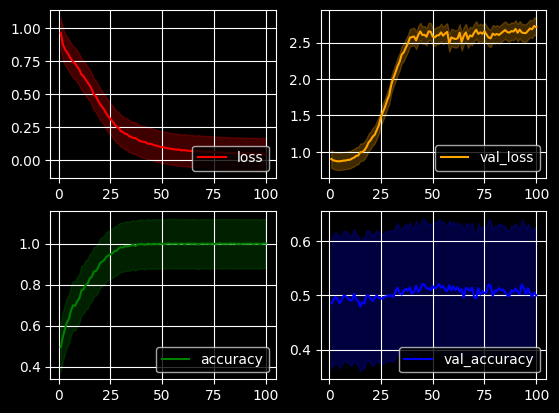

In [79]:
model_stats = [[np.asarray(model_history.history["loss"]), np.asarray(model_history.history["val_loss"])], 
          [np.asarray(model_history.history["accuracy"]), np.asarray(model_history.history["val_accuracy"])]]

def show_results(model_data):

    labels = [["loss", "val_loss"], ["accuracy", "val_accuracy"]]
    colors = [["red", "orange"], ["green", "blue"]]

    plt.style.use("dark_background")
    fig, axis = plt.subplots(nrows=2, ncols=2)
    for sample in range(len(axis)):

        axis[sample][0].plot(range(1, model_stats[sample][0].shape[0] + 1), model_stats[sample][0], color=colors[sample][0], label=labels[sample][0])
        axis[sample][0].fill_between(range(1, model_stats[sample][0].shape[0] + 1), model_stats[sample][0] - 0.12, model_stats[sample][0] + 0.12, color=colors[sample][0], alpha=0.25)
        
        axis[sample][1].plot(range(1, model_stats[sample][1].shape[0] + 1), model_stats[sample][1], color=colors[sample][1], label=labels[sample][1])
        axis[sample][1].fill_between(range(1, model_stats[sample][1].shape[0] + 1), model_stats[sample][1] - 0.12, model_stats[sample][1] + 0.12, color=colors[sample][1], alpha=0.25)

        axis[sample][0].legend(loc="lower right")
        axis[sample][0].grid()
        
        axis[sample][1].legend(loc="lower right")
        axis[sample][1].grid()

    plt.show()

show_results(model_data=model_stats)

In [86]:

test_data_buffer, test_person_info_buffer = data_loader(base_dir="c:\\Users\\1\\Desktop\\datasets", start_position=2000, max_data=4000)
test_data_tensor = generate_data_frame(test_data_buffer, test_person_info_buffer)

test_data_frame, test_data_tensor = generate_data_frame(test_data_buffer, test_person_info_buffer)

test_preprocessed_data = expand_randomization(test_data_tensor, need_shape=100)

train_data = test_preprocessed_data[:test_preprocessed_data.shape[0] // 2, :-1]
train_label = test_preprocessed_data[:test_preprocessed_data.shape[0] // 2, -1]

validation_data = test_preprocessed_data[test_preprocessed_data.shape[0] // 2:, :-1] 
validation_label = test_preprocessed_data[test_preprocessed_data.shape[0] // 2:, -1]

predicted_data = model.predict(train_data)
chiters_number = 0
none_chiters_number = 0

for (prediction_number, prediction) in enumerate(predicted_data):

    if prediction[0] > 0.55:
      
      print(f"subject number: [{prediction_number}] is chiter with probability: [{prediction[0]}]")
      chiters_number += 1
    
    else:
      
      print(f"subject number: [{prediction_number}] is not chiter with probability: [{1 - prediction[0]}]")
      none_chiters_number += 1
    

print(f"Total chiters number: [{chiters_number}], Total none chiters number: [{none_chiters_number}]")
      




41/41 [==============================] - 0s 675us/step
subject number: [0] is not chiter with probability: [0.8051449805498123]
subject number: [1] is chiter with probability: [0.9969460964202881]
subject number: [2] is not chiter with probability: [0.9962264904752374]
subject number: [3] is not chiter with probability: [0.9877761881798506]
subject number: [4] is not chiter with probability: [0.5809692442417145]
subject number: [5] is not chiter with probability: [0.8244062662124634]
subject number: [6] is chiter with probability: [0.9998730421066284]
subject number: [7] is chiter with probability: [0.999976634979248]
subject number: [8] is not chiter with probability: [0.9363562688231468]
subject number: [9] is not chiter with probability: [0.9997165382956155]
subject number: [10] is chiter with probability: [0.9985153079032898]
subject number: [11] is chiter with probability: [0.9999079704284668]
subject number: [12] is chiter with probability: [0.9945366978645325]
subject number: [1